In [1]:
import pathlib
import random
import string
import re
import numpy as np
import collections
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_text as text
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2021-10-27 14:26:32.376182: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Layers

In [2]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    
    def scaled_dot_product_attention(self, q, k, v, mask):
        """Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
        but it must be broadcastable for addition.

        Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
        output, attention_weights
        """

        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

        return output, attention_weights

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [3]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = self.point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
    @staticmethod
    def point_wise_feed_forward_network(d_model, dff):
        return tf.keras.Sequential([
                  tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                  tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                ])


In [4]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = self.point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    @staticmethod
    def point_wise_feed_forward_network(d_model, dff):
        return tf.keras.Sequential([
                  tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                  tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                ])

In [5]:
class TransformerModule(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TransformerModule, self).__init__(**kwargs)
        
    @staticmethod
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    @staticmethod
    def positional_encoding(position, d_model):
        angle_rads = TransformerModule.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)


In [6]:
class Encoder(TransformerModule):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        """
        Description
        """
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        """
        Description
        """

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)


In [7]:
class Decoder(TransformerModule):
    """
    description
    """
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        """
        descriptions
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [8]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, name="predictions")


    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights
    
    
    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = self.create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = self.create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = self.create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask
    
    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        
        self.optimizer = optimizer
        
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        
        # Create trackers
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
        
        
    @tf.function
    def train_step(self, batch):
        
        inp, tar = batch
        
        # offset target to make decoder input and decoder output - shifted by 1
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        with tf.GradientTape() as tape:
            # Get predictions
            predictions, _ = self([inp, tar_inp], training=True)
            
            # Compute loss
            loss = self.loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        # Compute metrics
        acc = self.accuracy_function(tar_real, predictions)
        
        # Update states
        self.train_loss(loss)
        self.train_accuracy(acc)
        
        return {"loss": self.train_loss.result(), "acc": self.train_accuracy.result() }
    
    
    def test_step(self, batch):
        
        inp, tar = batch
        
        # offset target to make decoder input and decoder output - shifted by 1
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]
        
        predictions, _ = self([inp, tar_inp], training=True)
    
        # compute metrics
        loss = self.loss_function(tar_real, predictions)
        acc = self.accuracy_function(tar_real, predictions)
        
        return {"loss": loss, "acc": acc}
        

    def accuracy_function(self, real, pred):
        accuracies = tf.equal(real, tf.argmax(pred, axis=2))

        mask = tf.math.logical_not(tf.math.equal(real, 0))
        accuracies = tf.math.logical_and(mask, accuracies)

        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracies)/tf.reduce_sum(mask) 
        
    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    
    
    @staticmethod
    def create_padding_mask(seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        # add extra dimensions to add the padding
        # to the attention logits.
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    @staticmethod
    def create_look_ahead_mask(size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

# Data

In [9]:
import tensorflow_text as text

In [10]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

In [11]:
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 400,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [12]:
tokenizer = text.BertTokenizer('./annotations_vocab.txt', **bert_tokenizer_params)

2021-10-27 14:26:49.588149: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-27 14:26:49.621441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 14:26:49.621963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2021-10-27 14:26:49.621996: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-27 14:26:49.632147: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-27 14:26:49.632222: I tensorflow/stream_executor/platform/

In [13]:
START = tf.convert_to_tensor(2, dtype=tf.int64)
END = tf.convert_to_tensor(3, dtype=tf.int64)

def add_start_end(ragged_tensor):
    count = ragged_tensor.bounding_shape()[0]
    starts = tf.fill([count, 1], START)
    ends = tf.fill([count, 1], END)
    return tf.concat([starts, ragged_tensor, ends], axis=1)

In [14]:
import os

def create_dataset(file_names, code_directory, annotation_directory, batch_size):
    """
    Creates a tf.dataset generator for both image codes and annotations.
    """
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    def get_annotation(fname):
        """
        dataset.map function
        """
        def parse_text_and_codes(filename):
            """
            Gets the text and codes for a filename
            """
            # Get code
            fnames = filename.numpy()
            codes = []
            for fname in fnames:
                fname = fname.decode()
                filename_code = os.path.join(code_directory, fname)
                code = np.ravel(np.load(filename_code))
                codes.append(code)

            # Get string
            strings = []
            for fname in fnames:
                fname = fname.decode()
                if "_lr" in fname:
                    fname = fname.replace("_lr", "")
                filename_string = os.path.join(annotation_directory, fname)
                string = np.load(filename_string)
                strings.append(string)

            return strings, codes


        string, code = tf.py_function(parse_text_and_codes, [fname], [tf.string, tf.int64])

        string = tokenizer.tokenize(string)
        string = string.merge_dims(-2,-1)
        # Add start and end
        string = add_start_end(string)
        # Convert from ragged to dense, padding with zeros.
        string = string.to_tensor()

        # ! --- Fixes a keras.model.fit bug --- !
        string.set_shape([None for _ in range(2)])
        code.set_shape([None for _ in range(2)])

        return code, string
    
    n = len(file_names)
    data_gen = tf.data.Dataset.from_tensor_slices(file_names)
    data_gen = data_gen.batch(batch_size)
    data_gen = data_gen.map(get_annotation, num_parallel_calls=AUTOTUNE)
    data_gen = data_gen.shuffle(buffer_size=256)
    data_gen = data_gen.prefetch(AUTOTUNE)
    data_gen = data_gen.repeat()
    
    return data_gen, n

In [15]:
BATCH_SIZE = 12
TRAIN_DIR = "/home/simon/Desktop/Project3/representations/train_codes"
VAL_DIR = "/home/simon/Desktop/Project3/representations/validation_codes"
TEST_DIR = "/home/simon/Desktop/Project3/representations/test_codes"
ANNOTATION_DIR = "/home/simon/Documents/Programming/Project3/annotations_trimmed"

train_files = os.listdir(TRAIN_DIR)
val_files = os.listdir(VAL_DIR)
test_files = os.listdir(TEST_DIR)

In [16]:
train_files = [t for t in train_files if "21H" not in t]

In [17]:
train_gen, N = create_dataset(file_names=train_files,
                              code_directory=TRAIN_DIR,
                              annotation_directory=ANNOTATION_DIR,
                              batch_size=BATCH_SIZE)

In [18]:
val_gen, VN = create_dataset(file_names=val_files,
                              code_directory=VAL_DIR,
                              annotation_directory=ANNOTATION_DIR,
                              batch_size=BATCH_SIZE)

In [19]:
test_gen, TN = create_dataset(file_names=test_files,
                              code_directory=TEST_DIR,
                              annotation_directory=ANNOTATION_DIR,
                              batch_size=1)

In [20]:
for batch in train_gen:
    break

2021-10-27 14:26:54.537585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-27 14:26:54.567002: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3099995000 Hz


In [21]:
x, y = batch

In [22]:
y.shape

TensorShape([12, 23])

# Training

In [69]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="./transformer_weights/weights-{epoch:02d}-{val_acc:.2f}.h5",
        monitor="val_acc",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    )

In [70]:
transformer = Transformer(
                    num_layers=4,
                    d_model=16,
                    num_heads=1,
                    dff=16,
                    input_vocab_size=2048,
                    target_vocab_size=250,
                    pe_input=256,
                    pe_target=100,
                    rate=0.1
                )

In [71]:
_ = transformer(batch)

transformer.summary()

Model: "transformer_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_3 (Encoder)          multiple                  39552     
_________________________________________________________________
decoder_3 (Decoder)          multiple                  15264     
_________________________________________________________________
predictions (Dense)          multiple                  4250      
Total params: 59,066
Trainable params: 59,066
Non-trainable params: 0
_________________________________________________________________


In [72]:
transformer.compile(optimizer=tf.keras.optimizers.Adam(0.001))

In [73]:
history = transformer.fit(train_gen,
                epochs=50,
                steps_per_epoch=N // BATCH_SIZE,
                validation_data=val_gen,
                validation_steps=VN // BATCH_SIZE,
                callbacks=[checkpoint]
             )

Epoch 1/50
964/964 [==============================] - 38s 29ms/step - loss: 2.2648 - acc: 0.5771 - val_loss: 0.2558 - val_acc: 0.9046

Epoch 00001: val_acc improved from -inf to 0.90458, saving model to ./transformer_weights/weights-01-0.90.h5
Epoch 2/50
964/964 [==============================] - 29s 30ms/step - loss: 0.2261 - acc: 0.9214 - val_loss: 0.1788 - val_acc: 0.9246

Epoch 00002: val_acc improved from 0.90458 to 0.92460, saving model to ./transformer_weights/weights-02-0.92.h5
Epoch 3/50
964/964 [==============================] - 29s 30ms/step - loss: 0.1871 - acc: 0.9289 - val_loss: 0.2167 - val_acc: 0.9288

Epoch 00003: val_acc improved from 0.92460 to 0.92884, saving model to ./transformer_weights/weights-03-0.93.h5
Epoch 4/50
964/964 [==============================] - 28s 29ms/step - loss: 0.1728 - acc: 0.9337 - val_loss: 0.1981 - val_acc: 0.9062

Epoch 00004: val_acc did not improve from 0.92884
Epoch 5/50
964/964 [==============================] - 28s 29ms/step - loss: 0

In [74]:
# 96.34% VAL

In [75]:
history = transformer.history

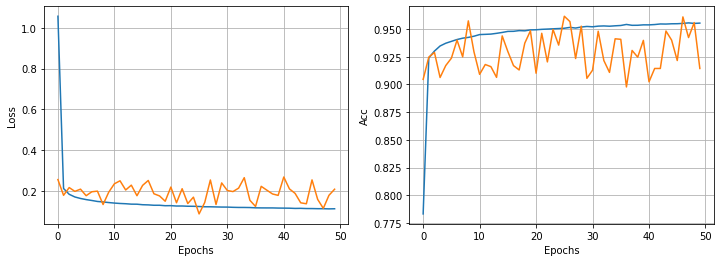

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4) )
for k in ["loss", "val_loss"]:
    y = history.history[k]
    x = range(len(y))
    ax[0].plot(x, y, label=k)
    
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid()
    
for k in ["acc", "val_acc"]:
    y = history.history[k]
    x = range(len(y))
    ax[1].plot(x, y, label=k)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Acc")
ax[1].grid()

plt.show()


In [77]:
val = transformer.evaluate(val_gen, steps=VN // BATCH_SIZE)

230/230 [==============================] - 5s 12ms/step - loss: 0.2060 - acc: 0.9278


In [78]:
test = transformer.evaluate(test_gen, steps=TN // BATCH_SIZE)

218/218 [==============================] - 3s 11ms/step - loss: 0.2156 - acc: 0.9242


In [54]:
transformer.load_weights("./transformer_weights/checkpoint.h5")

OSError: Unable to open file (file signature not found)

In [52]:
TN // BATCH_SIZE

218

In [336]:
BATCH_SIZE

12

# Decode Predictions

In [337]:
for batch in val_gen:
    break

In [338]:
indx   = 4
x      = batch[0][indx][tf.newaxis]
y_real = batch[1][indx][tf.newaxis]

In [339]:
x.shape

TensorShape([1, 256])

In [340]:
seq_pred, attn = transformer([x, y_real])

In [341]:
seq_pred = seq_pred[0].numpy()

In [342]:
seq = np.argmax(seq_pred, axis=-1)

In [343]:
seq.shape

(24,)

In [344]:
def cleanup_text(reserved_tokens, token_txt):
    # Drop the reserved tokens, except for "[UNK]".
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
    bad_token_re = "|".join(bad_tokens)

    bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
    result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

    # Join them into strings.
    result = tf.strings.reduce_join(result, separator=' ', axis=-1)[0]
    
    return result.numpy().decode()

In [345]:
i = np.where(seq == 3)[0][0] 
text = tokenizer.detokenize(tf.convert_to_tensor(seq[:i][np.newaxis]))
result = cleanup_text(reserved_tokens, text)

In [346]:
print(result)

the upper layer shows fragmented . the epidermis shows full dysplasia . the dermis appears normal .


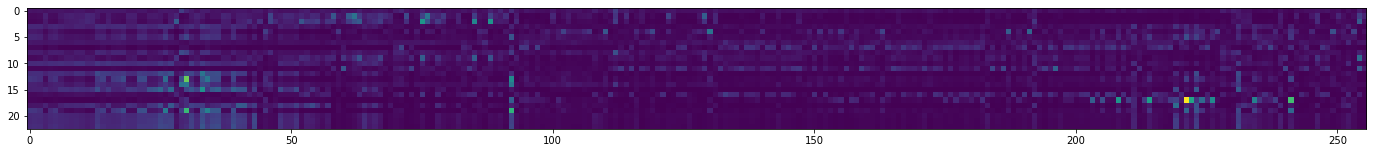

In [49]:
attn_map = attn["decoder_layer4_block2"][0][0]

plt.figure(figsize=(24, 4))
plt.imshow(attn_map)
plt.show()

# Generate From Scratch

In [669]:
def sample_from(logits, top_k=10, temp=1.0):
    logits, indices = tf.math.top_k(logits/temp, k=top_k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
    preds = np.asarray(preds).astype("float32")
    c = np.random.choice(indices, p=preds)
    return c, indices, preds

In [680]:
# Start with [START]
y_placeholder = np.array([[2]])

while y_placeholder.shape[-1] < 100:
    
    logits, attn = transformer([x, y_placeholder])
    
    #print("attn shape:", attn["decoder_layer4_block2"][0][0].shape)

    logits = logits[0].numpy()[-1]
    
    token, i_s, ps = sample_from(logits, top_k=2, temp=1)
    
    print(i_s, ps)
    # Update place holder
    y_placeholder = np.array([ list(y_placeholder[0]) +  [token] ])
    
    if token == 3: # [STOP]
        break
        
print(y_placeholder)

[28  5] [9.9999976e-01 1.8444528e-07]
[33 50] [1.0000000e+00 6.6900454e-09]
[30 56] [9.999993e-01 7.250684e-07]
[29 38] [9.9996483e-01 3.5202705e-05]
[50 41] [0.9785348  0.02146517]
[41 35] [0.94479924 0.05520073]
[ 5 55] [9.9998736e-01 1.2583198e-05]
[28 41] [1.000000e+00 2.130078e-08]
[32 38] [9.9999833e-01 1.6426899e-06]
[29 38] [9.9987376e-01 1.2621121e-04]
[39 49] [0.8780572  0.12194284]
[ 4 42] [9.9999976e-01 1.9976869e-07]
[40 41] [9.9999928e-01 7.0439955e-07]
[34 47] [1.0000000e+00 6.2109398e-09]
[ 5 55] [9.9999034e-01 9.6330541e-06]
[28  5] [1.0000000e+00 1.8722266e-08]
[31 47] [9.999944e-01 5.581095e-06]
[48 29] [0.7537015  0.24629852]
[46 37] [9.9999750e-01 2.4778797e-06]
[47 42] [9.9999678e-01 3.2387009e-06]
[ 5 55] [9.9998415e-01 1.5863534e-05]
[ 3 29] [9.9999976e-01 2.3224213e-07]
[[ 2 28 33 30 29 50 41  5 28 32 29 39  4 40 34  5 28 31 48 46 47  5  3]]


In [681]:
transformer.save_weights("./25_10_2021_transformer_model_weights.h5")

In [672]:
ps

array([9.9999976e-01, 2.7438219e-07], dtype=float32)

In [368]:
# Real
text = tokenizer.detokenize(tf.convert_to_tensor(y_real))
result = cleanup_text(reserved_tokens, text)
print("Answer:", result)
print()
# prediction
text = tokenizer.detokenize(tf.convert_to_tensor(y_placeholder))
result = cleanup_text(reserved_tokens, text)
print("Pred:", result)

Answer: the upper layer shows parakeratosis . the epidermis shows severe dysplasia . the dermis appears normal .

Pred: the upper layer shows fragmented basket weave keratosis . the epidermis shows full - thickness dysplasia . the dermis appears normal .


In [665]:
2 + 2

4

# Example with Image

In [369]:
import skimage.io as io
from skimage.transform import resize

In [435]:
files = os.listdir(TEST_DIR)

np.random.shuffle(files)

In [608]:
CASE = files[38]

# Load code
CODE = np.load(os.path.join(TEST_DIR, CASE))

# Load image
img = io.imread("/home/simon/Documents/Programming/Data/iec_1024/test_data/" + CASE.split(".")[0] + ".jpg")
img = resize(img, (256, 256))

# Load annoation
if "_lr" in CASE:
    CASE = CASE.replace("_lr", "")
y_real = np.load(os.path.join(ANNOTATION_DIR, CASE))

In [609]:
x = tf.convert_to_tensor(CODE.ravel()[np.newaxis])

In [635]:
attn_steps = []
# Start with [START]
y_placeholder = np.array([[2]])

while y_placeholder.shape[-1] < 100:
    
    logits, attn = transformer([x, y_placeholder])
    
    #print("attn shape:", attn["decoder_layer4_block2"][0][0].shape)
    attn_steps.append(attn["decoder_layer4_block2"][0][0].numpy())

    logits = logits[0].numpy()[-1]
    
    token = sample_from(logits, top_k=1, temp=1)
    
    # Update place holder
    y_placeholder = np.array([ list(y_placeholder[0]) +  [token] ])
    
    if token == 3: # [STOP]
        break
        
print(y_placeholder)

[[ 2 28 33 30 29 50 41  5 28 32 29 39  4 40 34  5 28 31 48 46 47  5  3]]


Caption: The upper layer shows thick parakeratosis. The epidermis shows full-thickness dysplasia. The dermis has been displaced.
Predict: The upper layer shows thick parakeratosis. The epidermis shows full - thickness dysplasia. The dermis has been displaced .


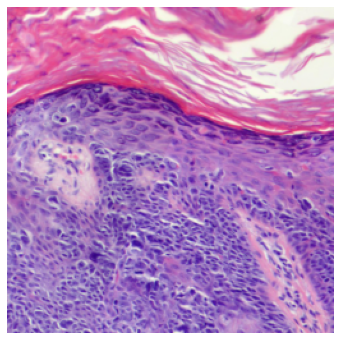

In [636]:
print("Caption:", y_real.flatten()[0])

# prediction
text = tokenizer.detokenize(tf.convert_to_tensor(y_placeholder))
result = cleanup_text(reserved_tokens, text)

result = ". ".join([r[0].upper() + r[1:-1] for r in result.split(". ")]) + "."

print("Predict:", result)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.show()


# Evaluate With Predictions

In [102]:
def predict(x):

    attn_steps = []
    # Start with [START]
    y_placeholder = np.array([[2]])

    while y_placeholder.shape[-1] < 100:

        logits, attn = transformer([x, y_placeholder])

        logits = logits[0].numpy()[-1]

        token = sample_from(logits, top_k=1, temp=1)

        # Update place holder
        y_placeholder = np.array([ list(y_placeholder[0]) +  [token] ])

        if token == 3: # [STOP]
            break

    return y_placeholder

In [115]:
count = 0
scores = { "ker": 0, "epi": 0, "der": 0}
for batch in test_gen:

    x, y_real = batch
    print(count, "of", TN, end="\r")
    
    #logits, attn = transformer(batch)
    
    y_pred = predict(x)
    
    # Real
    text = tokenizer.detokenize(tf.convert_to_tensor(y_real))
    answer = cleanup_text(reserved_tokens, text)

    # prediction
    text = tokenizer.detokenize(tf.convert_to_tensor(y_pred))
    prediction = cleanup_text(reserved_tokens, text)
    
    
    # Clean them more
    
    answer = answer.replace("the upper layer shows ", "")
    answer = answer.replace("the epidermis shows ", "")
    answer = answer.replace("the dermis ", "")
    
    prediction = prediction.replace("the upper layer shows ", "")
    prediction = prediction.replace("the epidermis shows ", "")
    prediction = prediction.replace("the dermis ", "")
    
    
    # Split them into three parts
    answer = answer.split(" . ")
    prediction = prediction.split(" . ")
    
    
    for a, p, k in zip(answer, prediction, scores.keys()):
        
        if a == p:
            scores[k] += 1
    
    
    #
    #break
    # Tally
    count += 1
    if count >= TN:
        break

#     if count >  48:
#         break

    if count % 30 == 0:
        print()
        for key in scores:
            print(key, scores[key]/count, end=" ")
        print()

29 of 2624
ker 0.3333333333333333 epi 0.5666666666666667 der 0.6666666666666666 
59 of 2624
ker 0.4 epi 0.6 der 0.75 
89 of 2624
ker 0.4 epi 0.6222222222222222 der 0.7444444444444445 
119 of 2624
ker 0.425 epi 0.625 der 0.7166666666666667 
149 of 2624
ker 0.38666666666666666 epi 0.6333333333333333 der 0.7333333333333333 
179 of 2624
ker 0.36666666666666664 epi 0.6388888888888888 der 0.7277777777777777 
209 of 2624
ker 0.36666666666666664 epi 0.6047619047619047 der 0.7333333333333333 
239 of 2624
ker 0.37916666666666665 epi 0.6 der 0.7291666666666666 
269 of 2624
ker 0.37407407407407406 epi 0.6 der 0.7333333333333333 
299 of 2624
ker 0.38333333333333336 epi 0.6 der 0.74 
329 of 2624
ker 0.38484848484848483 epi 0.603030303030303 der 0.7424242424242424 
359 of 2624
ker 0.38333333333333336 epi 0.5833333333333334 der 0.7444444444444445 
389 of 2624
ker 0.37948717948717947 epi 0.5820512820512821 der 0.7384615384615385 
419 of 2624
ker 0.3904761904761905 epi 0.5880952380952381 der 0.738095238

In [119]:
count = 0
for batch in test_gen:

    x, y_real = batch
    print(count, "of", TN, end="\r")
    
    #logits, attn = transformer(batch)
    
    y_pred = predict(x)
    
    # Real
    text = tokenizer.detokenize(tf.convert_to_tensor(y_real))
    answer = cleanup_text(reserved_tokens, text)

    # prediction
    text = tokenizer.detokenize(tf.convert_to_tensor(y_pred))
    prediction = cleanup_text(reserved_tokens, text)
    
    
    # Clean them more
    
    answer = answer.replace("the upper layer shows ", "")
    answer = answer.replace("the epidermis shows ", "")
    answer = answer.replace("the dermis ", "")
    
    prediction = prediction.replace("the upper layer shows ", "")
    prediction = prediction.replace("the epidermis shows ", "")
    prediction = prediction.replace("the dermis ", "")
    
    
    # Split them into three parts
    answer = answer.split(" . ")
    prediction = prediction.split(" . ")
    
    
    for a,p in zip(answer, prediction):
        print(a, p)
        
    print()
    
    count += 1
    if count >  5:
        break



fragmented basket weave keratosis thick basket weave keratosis
mild dysplasia mild dysplasia
appears solar damaged . appears solar damaged .

thin parakeratosis thin keratosis
full - thickness dysplasia full - thickness dysplasia
appears solar damaged . appears solar damaged .

eroded keratosis thin keratosis
severe dysplasia moderate dysplasia
appears normal . appears solar damaged .

basket weave keratosis basket weave keratosis
mild dysplasia moderate dysplasia
appears solar damaged . appears solar damaged .

basket weave keratosis basket weave keratosis
mild dysplasia mild dysplasia
appears solar damaged . appears solar damaged .

basket weave keratosis basket weave keratosis
moderate dysplasia severe dysplasia
appears abnormal . appears normal .



In [658]:
m = attn_steps[-1]

In [659]:
m = m.reshape((22, 16, 16))

In [660]:
masks = np.copy(m)

In [612]:
masks = []
for i, mask in enumerate(attn_steps):
    m = mask[i].reshape(16, 16)
    masks.append(m)

In [613]:
from matplotlib.transforms import Bbox

In [614]:
text

<tf.RaggedTensor [[b'[START]', b'the', b'upper', b'layer', b'shows', b'thick', b'parakeratosis', b'.', b'the', b'epidermis', b'shows', b'full', b'-', b'thickness', b'dysplasia', b'.', b'the', b'dermis', b'has', b'been', b'displaced', b'.', b'[END]']]>

In [663]:

blocks = []
row = np.zeros((16, 16))

count = 0
for i, m in enumerate(masks):
    
    s = text[0][i].numpy().decode()
    count += 1
    
    if s == ".":
        blocks.append(np.copy(row))
        # reset
        row = np.zeros((16, 16))
        count = 0
    else:
        m /= m.max()
        row += m
        
    print(s)

[START]
the
upper
layer
shows
thick
parakeratosis
.
the
epidermis
shows
full
-
thickness
dysplasia
.
the
dermis
has
been
displaced
.


3.582139333768282


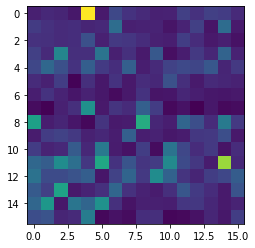

3.4101707611698657


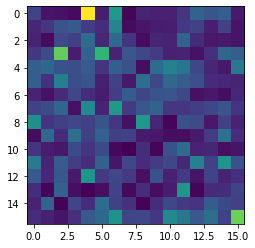

2.7363182455301285


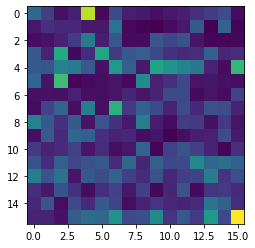

In [664]:
for b in blocks:
    
    print(b.max())
    plt.imshow(b)
    plt.show()

In [617]:
m.max()

0.026510451

In [71]:
my_dpi = 100 # Good default - doesn't really matter

# Size of output in pixels
h = 256
w = 256


blocks = []
row = []

for i, m in enumerate(masks[:-1]):
    
    m /= m.max()
    
    #m = resize(m, (32, 32), order=0)
    
    m = resize(m, (256, 256), order=0)[..., np.newaxis]
     
        
    fig, ax = plt.subplots(1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax.set_position([0, 0, 1, 1]) # Critical!
    
    title = text[0][i].numpy().decode()
    #ax[0].title(title)
    #ax.imshow(np.zeros((256, 256, 3)))
    #ax.imshow(np.dstack([img, m]))
    
    m[m < 0.2] = np.nan
    ax.imshow(img)
    ax.imshow(m, alpha=0.4)
    ax.axis("off")
    
    fig.savefig(f"/home/simon/Documents/Programming/Project3/out/{i:04d}_{title}.png",
            bbox_inches=Bbox([[0, 0], [w/my_dpi, h/my_dpi]]),
            dpi=my_dpi)
    
    plt.close()
    #
    #plt.show()